In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

/Users/rm/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


## Vamos a construir un primer modelo sin el reparto 

In [2]:
SeriesTV = pd.read_csv("/Users/rm/Desktop/MASTER DATA SCIENCE/TFM/SeriesModelo1.csv")
SeriesTV.head()

,Unnamed: 0,numberOfEpisodes,Finalization,originalTitle,startYear,endYear,runtimeMinutes,averageRating,numVotes,genre
0,1,50,0,Hana no mahoutsukai Mary Bell,1992,0,24,7.1,13,animation
1,2,7,1,La mujer de tu vida,1990,1990,60,6.1,39,comedy
2,3,31,1,The Detectives,1993,1997,50,7.4,1015,comedy
3,4,18,1,Fredrikssons fabrikk,1990,1993,30,6.5,212,comedy
4,5,40,0,Fushigi no umi no Nadia,1990,0,25,8.0,1250,adventure


In [3]:
SeriesTV = SeriesTV.drop('Unnamed: 0', 1)

In [4]:
SeriesTV.dtypes

numberOfEpisodes      int64
Finalization          int64
originalTitle        object
startYear             int64
endYear               int64
runtimeMinutes        int64
averageRating       float64
numVotes              int64
genre                object
dtype: object

In [5]:
SeriesTV.shape

(10743, 9)

## Featuring engineering

Vamos a tranformar la primera variable de género a 1 y 0. 

In [6]:
SeriesTV = pd.get_dummies(SeriesTV, columns=['genre'])

Vamos también a escalar el resto de variables numéricas. 
Tras probar varios metodologías, obtamos por MinMaxScaler. 

In [7]:
scaled_features = SeriesTV.copy()
col_names = ['startYear','runtimeMinutes','averageRating','numVotes']

In [8]:
#from sklearn.preprocessing import QuantileTransformer
#quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
#features = scaled_features[col_names]
#scaler = quantile_transformer.fit_transform(features.values)
#features = pd.DataFrame(scaler, index=SeriesTV.index, columns=col_names)
#scaled_features [col_names] = features
#scaled_features.head()

In [9]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,Normalizer
#Standardize the columns and re-assingn to original dataframe
features = scaled_features[col_names]
scaler = MinMaxScaler().fit_transform(features.values)
features = pd.DataFrame(scaler, index=SeriesTV.index, columns=col_names)
scaled_features [col_names] = features
scaled_features.head()

,numberOfEpisodes,Finalization,originalTitle,startYear,endYear,runtimeMinutes,averageRating,numVotes,genre_action,genre_adult,...,genre_horror,genre_musical,genre_mystery,genre_news,genre_romance,genre_sci-fi,genre_talk-show,genre_thriller,genre_war,genre_western
0,50,0,Hana no mahoutsukai Mary Bell,0.071429,0,0.194030,0.678161,0.000006,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,La mujer de tu vida,0.000000,1990,0.731343,0.563218,0.000025,0,0,...,0,0,0,0,0,0,0,0,0,0
2,31,1,The Detectives,0.107143,1997,0.582090,0.712644,0.000756,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18,1,Fredrikssons fabrikk,0.000000,1993,0.283582,0.609195,0.000155,0,0,...,0,0,0,0,0,0,0,0,0,0
4,40,0,Fushigi no umi no Nadia,0.000000,0,0.208955,0.781609,0.000932,0,0,...,0,0,0,0,0,0,0,0,0,0


Vamos a ver la correlación entre variables tras transformar

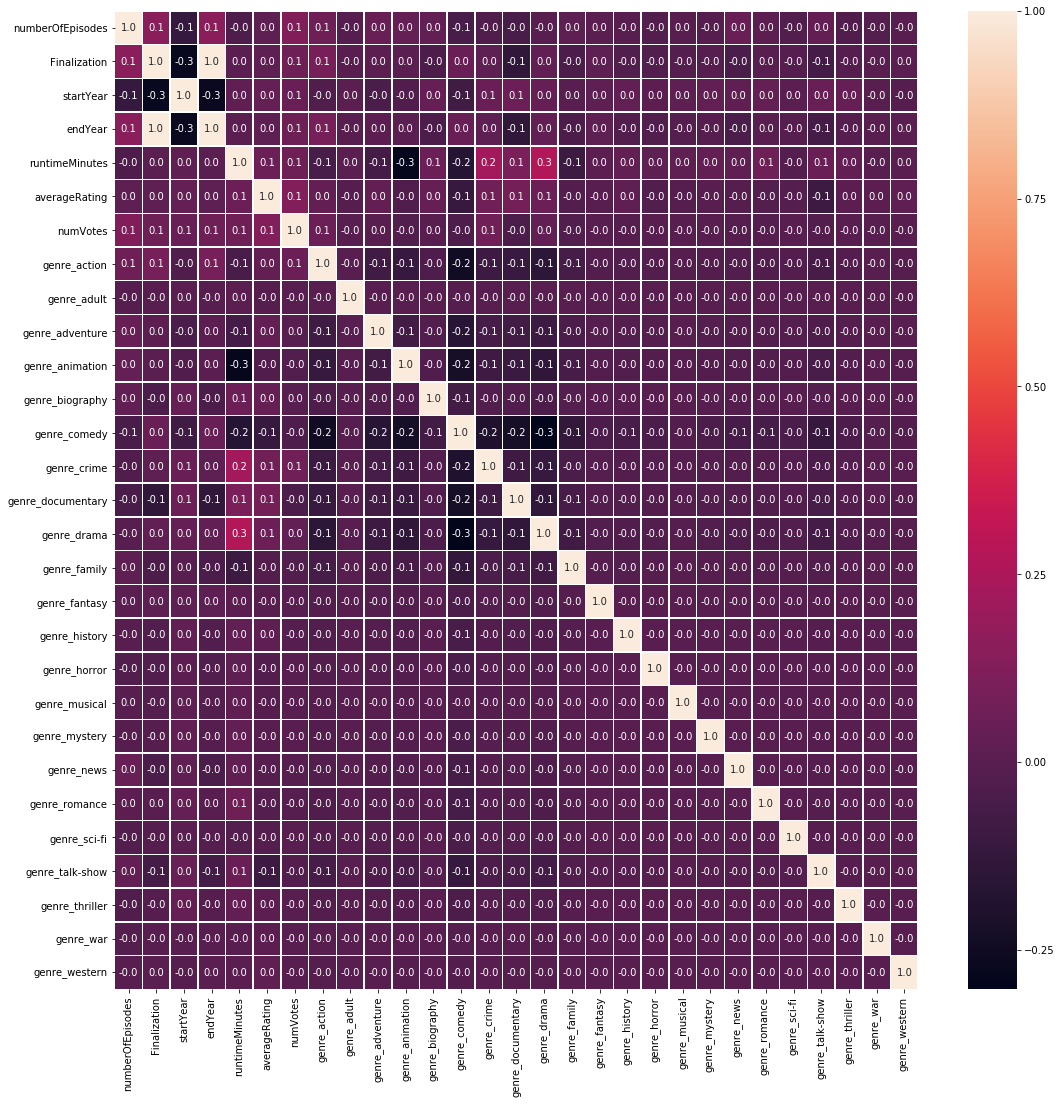

In [10]:
import seaborn as sns
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(scaled_features.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [11]:
#from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,Normalizer
# Standardize the columns and re-assingn to original dataframe
#features = scaled_features[col_names]
#scaler = RobustScaler().fit_transform(features.values)
#features = pd.DataFrame(scaler, index=SeriesTV.index, columns=col_names)
#scaled_features [col_names] = features
#scaled_features.head()

## Necesitamos entrenar con las series ya finalizadas para posteriormente predecir con las que no han terminado

In [12]:
subset_XTrain = scaled_features.loc[(scaled_features.Finalization == 1)]

In [13]:
X = subset_XTrain[list(set(subset_XTrain.columns)-set(["Finalization","numberOfEpisodes", "originalTitle", "endYear"]))].values
y = subset_XTrain ["numberOfEpisodes"]

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(2680, 26)
(1321, 26)
(2680,)
(1321,)


In [17]:
# Fijamos la seed y el modelo de evaluación
seed = 42
scoring = 'r2'

In [19]:
 from sklearn import linear_model
# Spot Check Algorithms
models = []
models.append(('Lasso', linear_model.Lasso(alpha = .5)))
models.append(('Ridge', linear_model.Ridge (alpha = .5)))
models.append(('ElasticNet', linear_model.ElasticNetCV(cv=3)))
models.append(('BayesianRidge',  linear_model.BayesianRidge()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Lasso: 0.023938 (0.010590)
Ridge: 0.070307 (0.032241)
ElasticNet: 0.054086 (0.026400)
BayesianRidge: 0.047314 (0.022781)


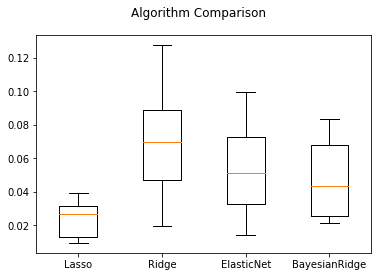

In [20]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

Escogemos el modelo con el mejor 'r2'

In [22]:
from sklearn.metrics import r2_score
# Make predictions on test dataset
bR =  linear_model.Ridge()
bR.fit(X_train, y_train)
predictions = bR.predict(X_test)
print(mean_absolute_error(y_test, predictions))
print(mean_squared_error(y_test, predictions))
print(r2_score(y_test, predictions))

17.5141210464
491.080179298
0.0329243023186


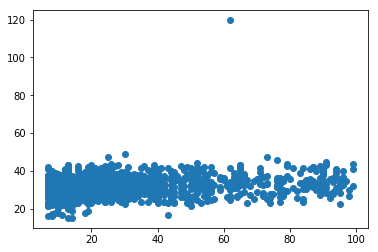

In [23]:
plt.scatter(y_test, predictions)

## The XGBoost Model

Fuente: https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py

In [23]:
#from sklearn.compose import TransformedTargetRegressor
#from sklearn.preprocessing import QuantileTransformer, quantile_transform
#import xgboost as xgb

#regr_trans = TransformedTargetRegressor(
    #regressor=xgb.XGBRegressor(),
    #transformer=QuantileTransformer(output_distribution='normal'))
#regr_trans.fit(X_train, y_train)
#y_pred = regr_trans.predict(X_test)

Realizamos la misma operación anterior con Subset_Xtrain

In [24]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

XGB primer modelo con Train

In [25]:
xgb = xgb.XGBRegressor(n_estimators = 250, max_depth = 3)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [26]:
y_pred1 = xgb.predict(X_test)
predictions1 = [round(value) for value in y_pred1]

In [27]:
max(y_pred1)

93.116547

In [28]:
min(y_pred1)

8.6228828

In [29]:
cross_val = cross_val_score(xgb, X, y, cv = 10).mean()
print("cross val: %f" % (cross_val))

score = xgb.score(X_test, y_test)
print ("score: %f" % (score))

mae = mean_absolute_error(y_test, predictions1)
print("MAE: %f" % (mae))

#print(mean_squared_error(y_test, predictions1))

r2 = r2_score(y_test, predictions1)
print("R2: %f" % (r2))

rmse = np.sqrt(mean_squared_error(y_test, predictions1))
print("RMSE: %f" % (rmse))

cross val: 0.138820
score: 0.130251
MAE: 16.180167
R2: 0.130600
RMSE: 21.011442


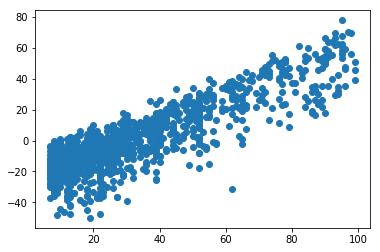

In [30]:
residuals = y_test - y_pred1
plt.scatter(y_test, residuals)

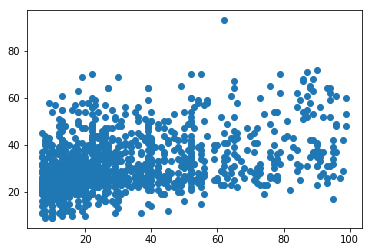

In [31]:
plt.scatter(y_test, predictions1)

In [32]:
#import pickle
#filename = 'finalized_model.sav'
#pickle.dump(xgb, open(filename, 'wb'))

In [33]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, y_test)
#print(result)

# GridSearch para afinar el modelo y volverlo a entrenar

In [34]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
xgb2 = GridSearchCV(estimator = XGBRegressor(),
                    param_grid = {"n_estimators" : np.arange(200, 450, 50), "max_depth" : np.arange(3, 6, 1)})
xgb2.fit(X, y)

/Users/rm/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([200, 250, 300, 350, 400]), 'max_depth': array([3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
print(xgb2.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [36]:
print(xgb2.best_params_)

{'max_depth': 3, 'n_estimators': 200}


In [37]:
xgbTrain= XGBRegressor(n_estimators = 200, max_depth = 3)
xgbTrain.fit(X, y)
# make predictions for test data
y_pred2 = xgbTrain.predict(X_test)

In [38]:
predictionsFinalTrain = [round(value) for value in y_pred2]

In [39]:
predictionsFinalTrain

[34.0,
 20.0,
 32.0,
 17.0,
 15.0,
 46.0,
 29.0,
 39.0,
 55.0,
 40.0,
 23.0,
 29.0,
 29.0,
 28.0,
 55.0,
 27.0,
 24.0,
 46.0,
 34.0,
 44.0,
 31.0,
 26.0,
 38.0,
 25.0,
 27.0,
 42.0,
 47.0,
 26.0,
 36.0,
 28.0,
 30.0,
 29.0,
 25.0,
 28.0,
 42.0,
 28.0,
 46.0,
 40.0,
 32.0,
 25.0,
 29.0,
 41.0,
 22.0,
 80.0,
 34.0,
 31.0,
 31.0,
 21.0,
 47.0,
 32.0,
 53.0,
 41.0,
 39.0,
 29.0,
 28.0,
 33.0,
 21.0,
 33.0,
 44.0,
 28.0,
 27.0,
 33.0,
 25.0,
 24.0,
 34.0,
 32.0,
 52.0,
 19.0,
 20.0,
 44.0,
 22.0,
 43.0,
 30.0,
 25.0,
 30.0,
 27.0,
 28.0,
 22.0,
 42.0,
 31.0,
 17.0,
 29.0,
 73.0,
 46.0,
 27.0,
 28.0,
 27.0,
 31.0,
 42.0,
 34.0,
 67.0,
 24.0,
 22.0,
 56.0,
 16.0,
 27.0,
 21.0,
 25.0,
 64.0,
 44.0,
 40.0,
 32.0,
 51.0,
 39.0,
 26.0,
 36.0,
 47.0,
 55.0,
 26.0,
 39.0,
 32.0,
 33.0,
 28.0,
 23.0,
 19.0,
 24.0,
 20.0,
 34.0,
 27.0,
 46.0,
 41.0,
 27.0,
 26.0,
 28.0,
 45.0,
 31.0,
 26.0,
 28.0,
 36.0,
 25.0,
 28.0,
 32.0,
 24.0,
 30.0,
 30.0,
 30.0,
 29.0,
 17.0,
 42.0,
 24.0,
 15.0,
 35.0,
 8.0,


In [40]:
cross_val = cross_val_score(xgbTrain, X, y, cv = 10).mean()
print("cross val: %f" % (cross_val))

score = xgbTrain.score(X_test, y_test)
print ("score: %f" % (score))

mae = mean_absolute_error(y_test, predictionsFinalTrain)
print("MAE: %f" % (mae))

#print(mean_squared_error(y_test, predictions1))

r2 = r2_score(y_test, predictionsFinalTrain)
print("R2: %f" % (r2))

rmse = np.sqrt(mean_squared_error(y_test, predictionsFinalTrain))
print("RMSE: %f" % (rmse))

cross val: 0.141371
score: 0.290444
MAE: 14.586677
R2: 0.289957
RMSE: 18.988402


## Predecir con el dataset completo de episodios no finalizados

In [41]:
subset_Xtest = scaled_features.loc[(scaled_features.Finalization == 0)]
X2 = subset_Xtest[list(set(subset_Xtest.columns)-set(["Finalization","numberOfEpisodes", "originalTitle", "endYear"]))].values
y2 = subset_Xtest ["numberOfEpisodes"]
#X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.99, random_state=42)

In [42]:
y_pred3 = xgbTrain.predict(X2)
predictionsFinalValidation = [round(value) for value in y_pred3]

In [43]:
cross_val = cross_val_score(xgbTrain, X2, y2, cv = 10).mean()
print("cross val: %f" % (cross_val))

score = xgbTrain.score(X2, y2)
print ("score: %f" % (score))

mae = mean_absolute_error(y2, predictionsFinalValidation)
print("MAE: %f" % (mae))

#print(mean_squared_error(y_test, predictions1))

r2 = r2_score(y2, predictionsFinalValidation)
print("R2: %f" % (r2))

rmse = np.sqrt(mean_squared_error(y2, predictionsFinalValidation))
print("RMSE: %f" % (rmse))

cross val: 0.076171
score: 0.032683
MAE: 15.093741
R2: 0.032598
RMSE: 19.892942


Text(0, 0.5, 'Predictions')

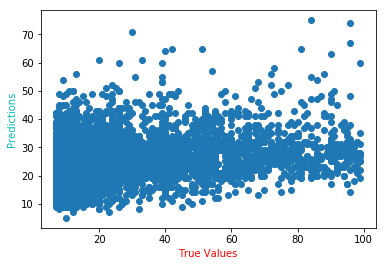

In [44]:
plt.scatter(y2, predictionsFinalValidation, marker = 'o')
plt.xlabel('True Values', color= 'r')
plt.ylabel('Predictions', color= 'c')

numberEpisodePrediction    0
dtype: int64

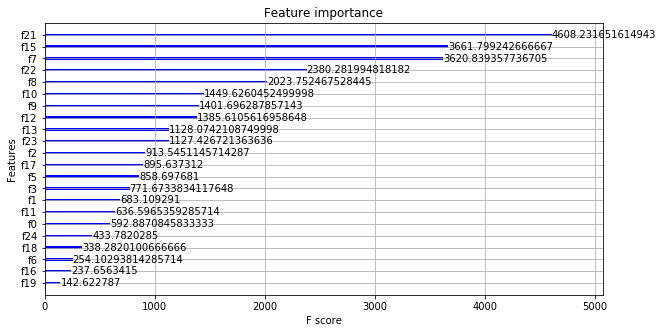

In [79]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgbTrain, ax = ax, importance_type = "gain", color = "blue")
plt.show()

In [ ]:
#dfPrediction = pd.DataFrame(predictions2)

In [ ]:
#dfPrediction.columns = ['numberEpisodePrediction']

In [ ]:
#df_out = pd.merge(subset_Xtest,dfPrediction,how = 'left',left_index = True, right_index = True) 

In [ ]:
#df_out

In [ ]:
#df_out.isna().sum()

### El modelo no ha podido predecir 3045 series

In [ ]:
df_out

In [ ]:
df_out.to_csv('df_out.csv', sep=',', encoding='utf-8')

## Vamos a probar el modelo contando con el número de actores y actrices por género

In [46]:
SeriesTV_2 = pd.read_csv("/Users/rm/Desktop/MASTER DATA SCIENCE/TFM/SeriesModelo2.csv")
SeriesTV_2.head()

,Unnamed: 0,numberOfEpisodes,Finalization,originalTitle,startYear,endYear,runtimeMinutes,averageRating,numVotes,genre,GenderMale,GenderFeMale
0,1,50,0,Hana no mahoutsukai Mary Bell,1992,0,24,7.1,13,animation,0,5
1,2,7,1,La mujer de tu vida,1990,1990,60,6.1,39,comedy,3,2
2,3,31,1,The Detectives,1993,1997,50,7.4,1015,comedy,5,0
3,4,18,1,Fredrikssons fabrikk,1990,1993,30,6.5,212,comedy,1,4
4,5,40,0,Fushigi no umi no Nadia,1990,0,25,8.0,1250,adventure,4,1


In [47]:
SeriesTV_2 = SeriesTV_2.drop('Unnamed: 0', 1)

In [48]:
SeriesTV_2 = pd.get_dummies(SeriesTV_2, columns=['genre'])

### Transformamos de la misma forma

In [49]:
SeriesTV_2.dtypes

numberOfEpisodes       int64
Finalization           int64
originalTitle         object
startYear              int64
endYear                int64
runtimeMinutes         int64
averageRating        float64
numVotes               int64
GenderMale             int64
GenderFeMale           int64
genre_action           uint8
genre_adult            uint8
genre_adventure        uint8
genre_animation        uint8
genre_biography        uint8
genre_comedy           uint8
genre_crime            uint8
genre_documentary      uint8
genre_drama            uint8
genre_family           uint8
genre_fantasy          uint8
genre_history          uint8
genre_horror           uint8
genre_musical          uint8
genre_mystery          uint8
genre_news             uint8
genre_romance          uint8
genre_sci-fi           uint8
genre_talk-show        uint8
genre_thriller         uint8
genre_war              uint8
genre_western          uint8
dtype: object

In [50]:
scaled_features_2 = SeriesTV_2.copy()
col_names_2 = ['startYear','runtimeMinutes','averageRating','numVotes', 'GenderMale', 'GenderFeMale']

In [51]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,Normalizer
#Standardize the columns and re-assingn to original dataframe
features_2 = scaled_features_2[col_names_2]
scaler_2 = MinMaxScaler().fit_transform(features_2.values)
features_2 = pd.DataFrame(scaler_2, index=SeriesTV_2.index, columns=col_names_2)
scaled_features_2 [col_names_2] = features_2
scaled_features_2.head()

,numberOfEpisodes,Finalization,originalTitle,startYear,endYear,runtimeMinutes,averageRating,numVotes,GenderMale,GenderFeMale,...,genre_horror,genre_musical,genre_mystery,genre_news,genre_romance,genre_sci-fi,genre_talk-show,genre_thriller,genre_war,genre_western
0,50,0,Hana no mahoutsukai Mary Bell,0.071429,0,0.194030,0.678161,0.000006,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,La mujer de tu vida,0.000000,1990,0.731343,0.563218,0.000025,0.6,0.4,...,0,0,0,0,0,0,0,0,0,0
2,31,1,The Detectives,0.107143,1997,0.582090,0.712644,0.000756,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,18,1,Fredrikssons fabrikk,0.000000,1993,0.283582,0.609195,0.000155,0.2,0.8,...,0,0,0,0,0,0,0,0,0,0
4,40,0,Fushigi no umi no Nadia,0.000000,0,0.208955,0.781609,0.000932,0.8,0.2,...,0,0,0,0,0,0,0,0,0,0


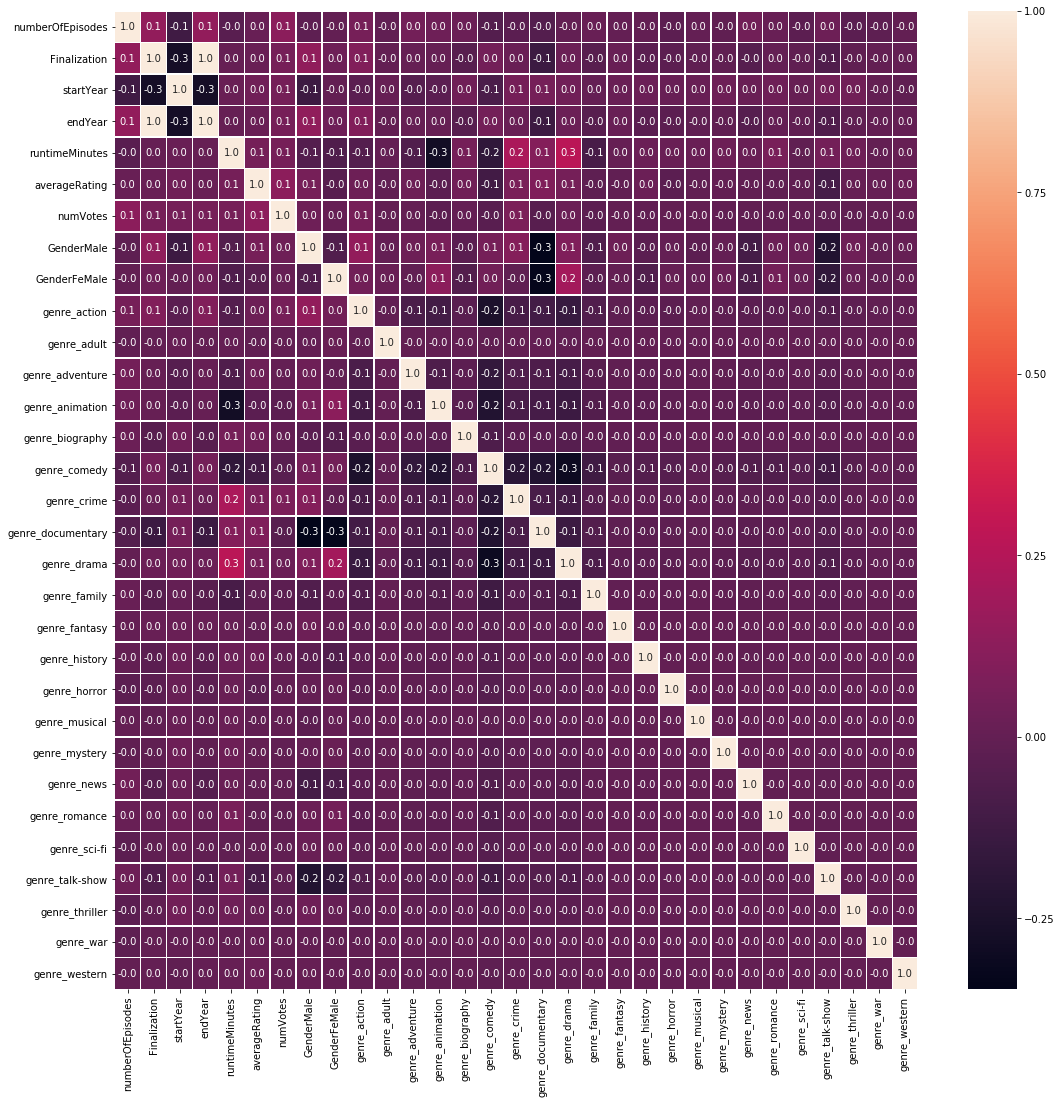

In [52]:
import seaborn as sns
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(scaled_features_2.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Dividimos de igual forma que la anterior

In [53]:
subset_XTrain_2 = scaled_features_2.loc[(scaled_features_2.Finalization == 1)]

In [54]:
X3 = subset_XTrain_2[list(set(subset_XTrain_2.columns)-set(["Finalization","numberOfEpisodes", "originalTitle", "endYear"]))].values
y3 = subset_XTrain_2 ["numberOfEpisodes"]

In [55]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.33, random_state=42)

In [57]:
xgbTrain_2 = xgb.XGBRegressor(n_estimators = 250, max_depth = 3)
xgbTrain_2.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [58]:
y_pred4 = xgbTrain_2.predict(X_test)
predictions2 = [round(value) for value in y_pred4]

In [59]:
cross_val = cross_val_score(xgbTrain_2, X3, y3, cv = 10).mean()
print("cross val: %f" % (cross_val))

score = xgbTrain_2.score(X_test, y_test)
print ("score: %f" % (score))

mae = mean_absolute_error(y_test, predictions2)
print("MAE: %f" % (mae))

#print(mean_squared_error(y_test, predictions1))

r2 = r2_score(y_test, predictions2)
print("R2: %f" % (r2))

rmse = np.sqrt(mean_squared_error(y_test, predictions2))
print("RMSE: %f" % (rmse))

cross val: 0.143563
score: 0.133418
MAE: 16.090083
R2: 0.132444
RMSE: 20.989147


## Nueva búsqueda de los mejores parámetros

In [60]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
xgb3 = GridSearchCV(estimator = XGBRegressor(),
                    param_grid = {"n_estimators" : np.arange(200, 450, 50), "max_depth" : np.arange(3, 6, 1)})
xgb3.fit(X3, y3)

/Users/rm/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([200, 250, 300, 350, 400]), 'max_depth': array([3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [62]:
print(xgb3.best_params_)

{'max_depth': 3, 'n_estimators': 200}


In [63]:
xgbTrain_2 = XGBRegressor(n_estimators = 200, max_depth = 3)
xgbTrain_2.fit(X3, y3)
# make predictions for test data
y_pred4 = xgbTrain_2.predict(X_test)

In [64]:
predictionsFinalTrain_2 = [round(value) for value in y_pred4]

In [65]:
cross_val = cross_val_score(xgbTrain_2, X3, y3, cv = 10).mean()
print("cross val: %f" % (cross_val))

score = xgbTrain_2.score(X_test, y_test)
print ("score: %f" % (score))

mae = mean_absolute_error(y_test, predictionsFinalTrain_2)
print("MAE: %f" % (mae))

#print(mean_squared_error(y_test, predictions1))

r2 = r2_score(y_test, predictionsFinalTrain_2)
print("R2: %f" % (r2))

rmse = np.sqrt(mean_squared_error(y_test, predictionsFinalTrain_2))
print("RMSE: %f" % (rmse))

cross val: 0.145378
score: 0.307714
MAE: 14.374716
R2: 0.306981
RMSE: 18.759383


In [80]:
dfPrediction = pd.DataFrame(predictionsFinalTrain_2)
dfPrediction.columns = ['numberEpisodePrediction']
dfPrediction.isna().sum()

numberEpisodePrediction    0
dtype: int64

## Como en la anterior ocasión, predecimos ahora con los terminados

In [66]:
subset_Xtest_2 = scaled_features_2.loc[(scaled_features_2.Finalization == 0)]
X4 = subset_Xtest_2[list(set(subset_Xtest_2.columns)-set(["Finalization","numberOfEpisodes", "originalTitle", "endYear"]))].values
y4 = subset_Xtest_2 ["numberOfEpisodes"]
#X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size=0.99, random_state=42)

In [67]:
y_pred5 = xgbTrain_2.predict(X4)
predictionsFinal = [round(value) for value in y_pred5]

In [68]:
cross_val = cross_val_score(xgbTrain_2, X4, y4, cv = 10).mean()
print("cross val: %f" % (cross_val))

score = xgbTrain_2.score(X4, y4)
print ("score: %f" % (score))

mae = mean_absolute_error(y4, predictionsFinal)
print("MAE: %f" % (mae))

#print(mean_squared_error(y_test, predictions1))

r2 = r2_score(y4, predictionsFinal)
print("R2: %f" % (r2))

rmse = np.sqrt(mean_squared_error(y4, predictionsFinal))
print("RMSE: %f" % (rmse))

cross val: 0.078918
score: 0.045447
MAE: 14.983684
R2: 0.044958
RMSE: 19.765460


### Este segundo modelo con el género, mejora al anterior siendo ambos resultados concluyentes que con los datos recolectados no se puede predecir cuando va a durar en capítulos una serie.

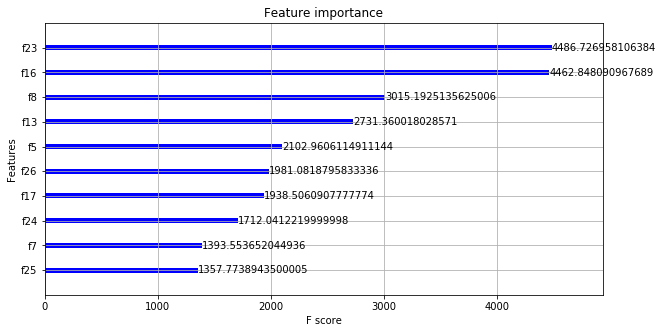

In [70]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgbTrain_2, ax = ax, importance_type = "gain", color = "blue", max_num_features=10)
plt.show()

In [71]:
sorted_idx = np.argsort(xgbTrain_2.feature_importances_)[::-1]

In [72]:

importance_X = subset_Xtest_2[list(set(subset_Xtest_2.columns)-set(["Finalization","numberOfEpisodes", "originalTitle", "endYear"]))]

In [73]:
importance_X.columns

Index(['genre_family', 'genre_history', 'genre_drama', 'genre_romance',
       'genre_horror', 'runtimeMinutes', 'genre_fantasy', 'averageRating',
       'genre_documentary', 'genre_news', 'genre_talk-show', 'genre_musical',
       'genre_sci-fi', 'genre_comedy', 'genre_western', 'genre_mystery',
       'numVotes', 'genre_action', 'GenderFeMale', 'genre_biography',
       'genre_adult', 'genre_crime', 'genre_thriller', 'startYear',
       'genre_animation', 'GenderMale', 'genre_adventure', 'genre_war'],
      dtype='object')

In [74]:
for index in sorted_idx:
    print([importance_X.columns[index], xgbTrain_2.feature_importances_[index]]) 

['numVotes', 0.27530676]
['averageRating', 0.18174846]
['runtimeMinutes', 0.16257669]
['startYear', 0.14417177]
['GenderMale', 0.050613496]
['GenderFeMale', 0.027607363]
['genre_comedy', 0.026840491]
['genre_biography', 0.017638037]
['genre_drama', 0.016871165]
['genre_romance', 0.013803681]
['genre_documentary', 0.012269938]
['genre_musical', 0.011503068]
['genre_adventure', 0.0092024542]
['genre_family', 0.0076687117]
['genre_animation', 0.0076687117]
['genre_action', 0.0069018407]
['genre_mystery', 0.0061349692]
['genre_talk-show', 0.0046012271]
['genre_fantasy', 0.0046012271]
['genre_horror', 0.0038343559]
['genre_crime', 0.0030674846]
['genre_history', 0.0030674846]
['genre_thriller', 0.0023006136]
['genre_western', 0.0]
['genre_sci-fi', 0.0]
['genre_news', 0.0]
['genre_adult', 0.0]
['genre_war', 0.0]


Guardamos las predicciones en un dataframe

In [95]:
dfPrediction = pd.DataFrame(predictionsFinal)
dfPrediction.columns = ['numberEpisodePrediction']
dfPrediction

,numberEpisodePrediction
0,38.0
1,44.0
2,30.0
3,33.0
4,29.0
5,26.0
6,27.0
7,26.0
8,25.0
9,26.0


In [ ]:
Para poder hacer el merge, tenemos que re-indexar el dataframe original para que concuerden sus índices

In [93]:
subset_Xtest_2 = subset_Xtest_2.reset_index(drop=True)
subset_Xtest_2

,numberOfEpisodes,Finalization,originalTitle,startYear,endYear,runtimeMinutes,averageRating,numVotes,GenderMale,GenderFeMale,...,genre_horror,genre_musical,genre_mystery,genre_news,genre_romance,genre_sci-fi,genre_talk-show,genre_thriller,genre_war,genre_western
0,50,0,Hana no mahoutsukai Mary Bell,0.071429,0,0.194030,0.678161,5.986272e-06,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,40,0,Fushigi no umi no Nadia,0.000000,0,0.208955,0.781609,9.316136e-04,0.8,0.2,...,0,0,0,0,0,0,0,0,0,0
2,12,0,Abenteuer Airport,0.000000,0,0.507463,0.494253,4.489704e-06,0.6,0.4,...,0,0,0,0,0,0,0,0,0,0
3,15,0,Bagdad Cafe,0.000000,0,0.283582,0.689655,1.938056e-04,0.4,0.6,...,0,0,0,0,0,0,0,0,0,0
4,11,0,Brewster Place,0.000000,0,0.283582,0.620690,3.965905e-05,0.2,0.8,...,0,0,0,0,0,0,0,0,0,0
5,7,0,Broken Badges,0.000000,0,0.731343,0.724138,2.843479e-05,0.6,0.2,...,0,0,0,0,0,0,0,0,0,0
6,13,0,Capital News,0.000000,0,0.731343,0.563218,8.231124e-06,0.8,0.0,...,0,0,0,0,0,0,0,0,0,0
7,33,0,Carol & Company,0.000000,0,0.283582,0.724138,5.312816e-05,0.4,0.6,...,0,0,0,0,0,0,0,0,0,0
8,13,0,City,0.000000,0,0.283582,0.528736,1.721053e-05,0.4,0.4,...,0,0,0,0,0,0,0,0,0,0
9,13,0,Claxon,0.035714,0,0.208955,0.770115,2.095195e-05,0.8,0.2,...,0,0,0,0,0,0,0,0,0,0


In [97]:
df_out = pd.merge(subset_Xtest_2,dfPrediction,how = 'left',left_index = True, right_index = True) 
df_out.to_csv('PredictionOfUnfinishedSeriesTV.csv', sep=',', encoding='utf-8')

In [98]:
df_out.isna().sum()

numberOfEpisodes           0
Finalization               0
originalTitle              0
startYear                  0
endYear                    0
runtimeMinutes             0
averageRating              0
numVotes                   0
GenderMale                 0
GenderFeMale               0
genre_action               0
genre_adult                0
genre_adventure            0
genre_animation            0
genre_biography            0
genre_comedy               0
genre_crime                0
genre_documentary          0
genre_drama                0
genre_family               0
genre_fantasy              0
genre_history              0
genre_horror               0
genre_musical              0
genre_mystery              0
genre_news                 0
genre_romance              0
genre_sci-fi               0
genre_talk-show            0
genre_thriller             0
genre_war                  0
genre_western              0
numberEpisodePrediction    0
dtype: int64

## DASHBOARD APARCHE SUPERSET

## Vamos a construir un dashboard a partir del csv de prediciones y posteriormente trabajaremos con Apache Superset

In [100]:
import os
cwd = os.getcwd()

In [101]:
cwd

'/Users/rm/Desktop/MASTER DATA SCIENCE/TFM'

In [102]:
series = pd.read_csv('PredictionOfUnfinishedSeriesTV.csv', error_bad_lines=False) # read csv file
series = series.drop('Unnamed: 0', 1)
series


,numberOfEpisodes,Finalization,originalTitle,startYear,endYear,runtimeMinutes,averageRating,numVotes,GenderMale,GenderFeMale,...,genre_musical,genre_mystery,genre_news,genre_romance,genre_sci-fi,genre_talk-show,genre_thriller,genre_war,genre_western,numberEpisodePrediction
0,50,0,Hana no mahoutsukai Mary Bell,0.071429,0,0.194030,0.678161,5.986272e-06,0.0,1.0,...,0,0,0,0,0,0,0,0,0,38.0
1,40,0,Fushigi no umi no Nadia,0.000000,0,0.208955,0.781609,9.316136e-04,0.8,0.2,...,0,0,0,0,0,0,0,0,0,44.0
2,12,0,Abenteuer Airport,0.000000,0,0.507463,0.494253,4.489704e-06,0.6,0.4,...,0,0,0,0,0,0,0,0,0,30.0
3,15,0,Bagdad Cafe,0.000000,0,0.283582,0.689655,1.938056e-04,0.4,0.6,...,0,0,0,0,0,0,0,0,0,33.0
4,11,0,Brewster Place,0.000000,0,0.283582,0.620690,3.965905e-05,0.2,0.8,...,0,0,0,0,0,0,0,0,0,29.0
5,7,0,Broken Badges,0.000000,0,0.731343,0.724138,2.843479e-05,0.6,0.2,...,0,0,0,0,0,0,0,0,0,26.0
6,13,0,Capital News,0.000000,0,0.731343,0.563218,8.231124e-06,0.8,0.0,...,0,0,0,0,0,0,0,0,0,27.0
7,33,0,Carol & Company,0.000000,0,0.283582,0.724138,5.312816e-05,0.4,0.6,...,0,0,0,0,0,0,0,0,0,26.0
8,13,0,City,0.000000,0,0.283582,0.528736,1.721053e-05,0.4,0.4,...,0,0,0,0,0,0,0,0,0,25.0
9,13,0,Claxon,0.035714,0,0.208955,0.770115,2.095195e-05,0.8,0.2,...,0,0,0,0,0,0,0,0,0,26.0


In [103]:
import sqlite3
import pandas as pd

sqlite_file = '/Users/rm/Desktop/MASTER DATA SCIENCE/TFM/PredictionOfUnfinishedSeriesTV.db' # the DB file
conn = sqlite3.connect(sqlite_file) # establish a sqlite3 connection

# put the dataframe in DB 
series.to_sql('PredictionOfUnfinishedSeriesTV', conn, if_exists='append', index=False)

conn.close()


#Continuamos en Superset